# Classifying Patient Abilify Ratings from WebMD

## Setup

In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
import gensim

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# download WordNet model for lemmatization

nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [3]:
# load dataset
# https://www.kaggle.com/datasets/joyshil0599/abilify-oral-reviews-dataset

corpus = pd.read_csv('/kaggle/input/abilify-oral-reviews-dataset/abilify_ora_effected_peple_reviewl.csv',
                     encoding_errors='replace') # use replacement character for characters not in UTF-8
corpus = corpus[['overall-rating', 'description-text']]

print(f'Before dropping NAs: {len(corpus)}')
corpus = corpus.dropna(axis=0)
corpus = corpus.reset_index(drop=True)
print(f'After dropping NAs: {len(corpus)}')

corpus.head(5)

Before dropping NAs: 1835
After dropping NAs: 1540


,overall-rating,description-text
0,5.0,I've taken Abilify to augment bupropion for Bi...
1,2.0,Worked for 3 months. Waste of time. You think ...
2,2.3,Worked really well for like 2 months then I go...
3,1.0,This is the worst drug on the market. It cause...
4,2.0,I was prescribed as a child at 15 years old. I...


## Exploratory Data Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


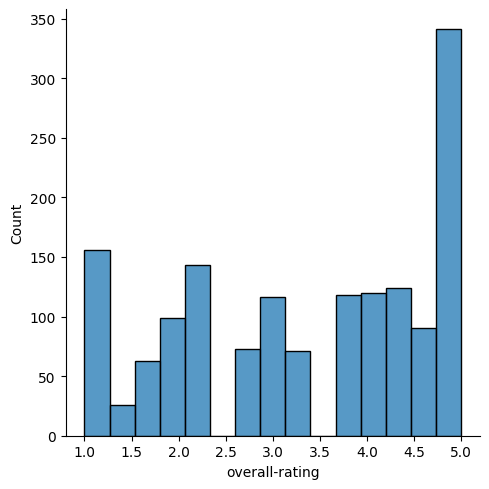

In [4]:
ax = sns.displot(corpus, x='overall-rating', bins=15)
# midpoints = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
# ax.set_xticks(midpoints)

plt.show()

<Axes: xlabel='rating_rounded', ylabel='count'>

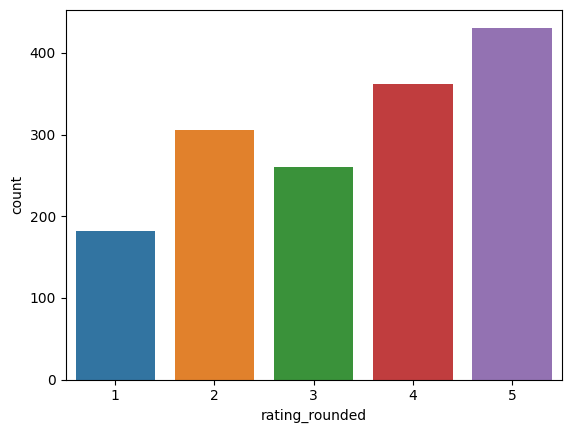

In [5]:
corpus['rating_rounded'] = corpus['overall-rating'].round().astype(int)
sns.countplot(corpus, x='rating_rounded')

## Text Preprocessing
https://geeksforgeeks.org/python-word-embedding-using-word2vec/ \
https://spotintelligence.com/2022/12/21/nltk-preprocessing-pipeline/

In [6]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.5 MB/s eta 0:00:0000:0100:01


In [8]:
from spellchecker import SpellChecker
from tqdm import tqdm

corpus['spellchecked-text'] = corpus['description-text']

speller = SpellChecker()
for i, sentence in enumerate(tqdm(corpus['description-text'])):
    words = sentence.split(' ')
    corpus.loc[i, 'spellchecked-text'] = ' '.join([speller.correction(word) if speller.correction(word) is not None else word for word in words])

100%|██████████| 1540/1540 [15:27<00:00,  1.66it/s]


In [9]:
corpus.head(10)

,overall-rating,description-text,rating_rounded,spellchecked-text
0,5.0,I've taken Abilify to augment bupropion for Bi...,5,I've taken ability to augment bupropion for Bi...
1,2.0,Worked for 3 months. Waste of time. You think ...,2,Worked for 3 months Waste of time You think yo...
2,2.3,Worked really well for like 2 months then I go...,2,Worked really well for like 2 months then I go...
3,1.0,This is the worst drug on the market. It cause...,1,This is the worst drug on the market It caused...
4,2.0,I was prescribed as a child at 15 years old. I...,2,I was prescribed as a child at 15 years old It...
5,2.7,ABILIFY IS POISON. IT CAUSED ME TO BE A COMPUL...,3,ability IS poison IT CAUSED ME TO BE A COMPULS...
6,3.3,My sister has been taking Ability for about 3y...,3,My sister has been taking Ability for about yr...
7,3.7,I've been on Lexapro for 15 years for dysthymi...,4,I've been on Lexapro for 15 years for dysthymi...
8,3.3,"This worked great to stabilize my mood, howeve...",3,This worked great to stabilize my mood however...
9,2.3,Nightmarish to say the least. Gave me suicidal...,2,Nightmarish to say the least Gave me suicidal ...


In [10]:
np.sum(corpus['description-text'] == corpus['spellchecked-text'])

115

In [11]:
# make into sklearn pipeline

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# add spell checking
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens_lower = [token.lower() for token in tokens]
    tokens_no_punct = [token for token in tokens_lower if token not in string.punctuation]
    # tokens_no_stopwords = [token for token in tokens_no_punct if token not in stopwords]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_no_punct]
    sentence = ' '.join(tokens_lemmatized)
    return sentence

In [12]:
corpus['text_preprocessed'] = corpus['spellchecked-text'].apply(preprocess_text)
corpus['text_preprocessed'].head(5)

0    i 've taken ability to augment bupropion for b...
1    worked for 3 month waste of time you think you...
2    worked really well for like 2 month then i got...
3    this is the worst drug on the market it caused...
4    i wa prescribed a a child at 15 year old it ca...
Name: text_preprocessed, dtype: object

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 3000
MAX_SEQUENCE_LENGTH = 150

tokenizer = Tokenizer(oov_token='<OOV>', num_words=VOCAB_SIZE)

sentences = corpus['text_preprocessed']

# generate word indexes
tokenizer.fit_on_texts(sentences)

# generate sequences and apply padding
sequences = tokenizer.texts_to_sequences(sentences)
sequences_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [14]:
words_sentences = [x.split() for x in sentences]

## Set up Evaluation Metrics

In [15]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

def evaluation(y_test, y_pred):
    print(f'accuracy: {accuracy_score(y_test, y_pred):.4f}')

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test) + 1  # sorted in ascending order
    cm_plot = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm_plot.plot(cmap='Blues', ax=ax)
    im = cm_plot.im_
    im.colorbar.remove()
    plt.colorbar(im, orientation='horizontal', pad=0.2, label='Number of samples')

    plt.title('');

## Bag of Words and Naive Bayes
Adapted from Natural Language Processing in Action book[](http://)

In [16]:
# produce BOW

from collections import Counter                                    

bags_of_words = [Counter(sentence) for sentence in words_sentences]
df_bows = pd.DataFrame.from_records(bags_of_words)                  
df_bows = df_bows.fillna(0).astype(int)
df_bows.head(5)

,i,'ve,taken,ability,to,augment,bupropion,for,bipolar,disorder,...,welt,true,unhappy,environment,behind,wheel,full-blown,interferes,weekend,alleviating
0,4,2,1,1,1,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# train-test split

from sklearn.model_selection import train_test_split

y = corpus['rating_rounded'] - 1  # get labels 0-4 instead of 1-5

test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(df_bows,
                                                    y,
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

# subset of 1 and 5 star ratings
keep_train = (y_train == 0) | (y_train == 4)
keep_test = (y_test == 0) | (y_test == 4)

X_train_subset = X_train[keep_train]
y_train_subset = y_train[keep_train]
y_train_subset = np.array([y if y==0 else 1 for y in y_train_subset])

X_test_subset = X_test[keep_test]
y_test_subset = y_test[keep_test]
y_test_subset = np.array([y if y==0 else 1 for y in y_test_subset])

accuracy: 0.7710


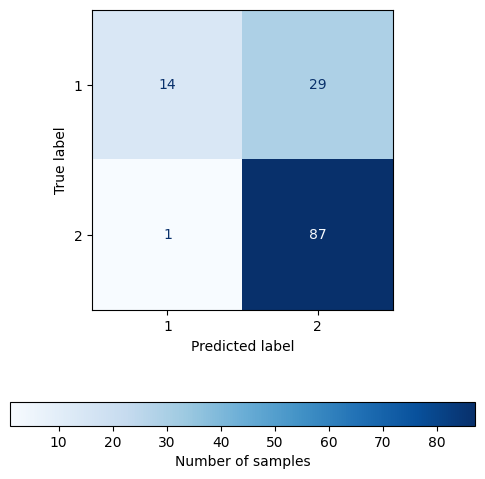

In [18]:
# fit naive Bayes, predict, and evaluate performance

from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_subset, y_train_subset)

y_pred = model.predict(X_test_subset)

evaluation(y_test_subset, y_pred)

In [19]:
# inspect some misclassified samples

one_star_misclassified = X_test_subset[(y_test_subset == 0) & (y_pred == 1)]
for row in one_star_misclassified.iterrows():
    print(one_star_misclassified.columns[row[1] != 0])

Index(['i', 'ability', 'now', 'it', ''s', 'effect', 'of', '2', 'wa', 'just',
       'is', 'than', 'before', 'long', 'eating', 'an', 'about', 'ago', 'how',
       'feel', 'am', 'le', 'health', 'began', '...', 'concerned', 'sleeping',
       'nausea', 'horrible..trouble', 'therapeutic', 'rn..and', 'risks/side',
       'desired', 'helpfullness'],
      dtype='object')
Index(['i', 'to', 'and', 'it', 'the', 'from', 'all', 'my', 'wa', 'with',
       'having', 'on', 'over', 'or', 'out', 'very', 'up', 'rash', 'body',
       'felt', 'when', 'sent', 'energy', 'right', 'came', 'room', 'emergency',
       'ended', 'emotion', 'switched', 'geodon', 'numb', 'inside', 'welt',
       'true', 'unhappy'],
      dtype='object')
Index(['i', 'to', 'for', 'and', 'depression', 'year', 'it', 'the', 'a', 'of',
       'month', 'better', 'really', 'my', 'with', 'this', 'is', 'on', 'me',
       'company', 'in', 'an', 'insurance', 'added', 'issue', 'feeling',
       'helped', 'am', 'until', 'when', 'first', 'finall

## TF-IDF and Latent Semantic Analysis (LSA)
Adapted from Natural Language Processing in Action book[](http://)

In [20]:
# produce TF-IDF matrix

from sklearn.feature_extraction.text import TfidfVectorizer

extreme_bool = (y == 0) | (y == 4)

tfidf_model = TfidfVectorizer()
tfidf_matrix = tfidf_model.fit_transform(sentences[extreme_bool]).toarray()
tfidf_matrix = tfidf_matrix - tfidf_matrix.mean(axis=0) # center data
tfidf_matrix = (tfidf_matrix.T / np.linalg.norm(tfidf_matrix, axis=1)).T  # normalize with L2 norm (vector length)
tfidf_matrix[:5]

array([[-0.00107595, -0.00032789, -0.00121306, ..., -0.00161719,
        -0.00036612, -0.00258395],
       [-0.00108793, -0.00033154, -0.00122657, ..., -0.0016352 ,
        -0.0003702 , -0.00261272],
       [-0.0010875 , -0.00033141, -0.00122608, ..., -0.00163455,
        -0.00037005, -0.00261168],
       [-0.00111056, -0.00033844, -0.00125208, ..., -0.00166921,
        -0.0003779 , -0.00266706],
       [-0.00110404, -0.00033645, -0.00124473, ..., -0.00165941,
        -0.00037568, -0.00265141]])

In [21]:
# perform truncated SVD

from sklearn.decomposition import TruncatedSVD
 
svd = TruncatedSVD(n_components=16, n_iter=100)
svd_topic_vectors = svd.fit_transform(tfidf_matrix)

<Axes: >

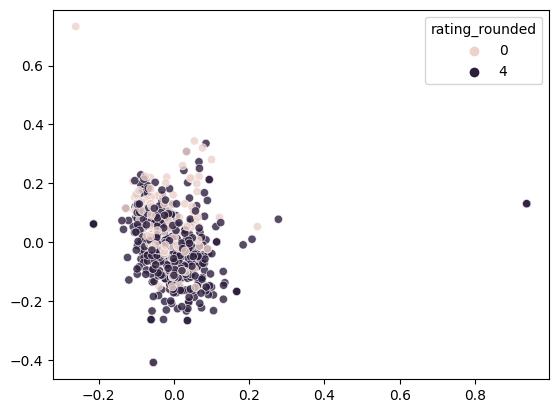

In [22]:
# plot first 2 PCs and color by 1 vs 5 star reviews

x_coord = np.array([doc[0] for doc in svd_topic_vectors])
y_coord = np.array([doc[1] for doc in svd_topic_vectors])

sns.scatterplot(x=x_coord, y=y_coord, hue=y[extreme_bool], alpha=0.8)

accuracy: 0.7317


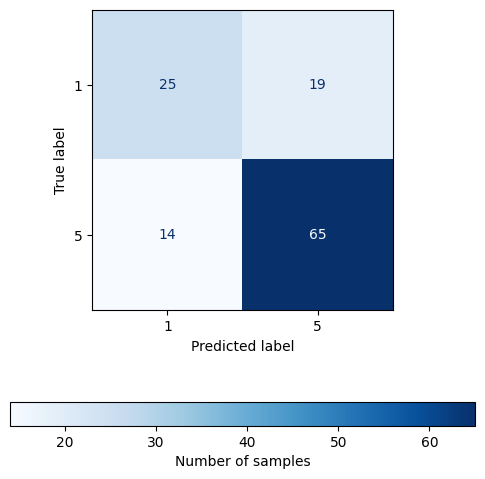

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train, X_test, y_train, y_test = train_test_split(svd_topic_vectors, y[extreme_bool], test_size=0.2, random_state=0)
model = LinearDiscriminantAnalysis(n_components=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

evaluation(y_test, y_pred)

## Word2Vec and Convolutional Neural Network (CNN)

In [24]:
EMBEDDING_DIM = 300

w2v_file = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(w2v_file, binary=True)

In [25]:
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [26]:
word_index = tokenizer.word_index
word_list = sorted(word_index.items(), key=lambda x:x[1])
word_list = [x[0] for x in word_list]

embedding_matrix = np.vstack([np.zeros([1, EMBEDDING_DIM]),
                             np.array([w2v_model[word] if word in w2v_model else np.zeros(EMBEDDING_DIM) for word in word_list])])

In [27]:
np.array(word_list)[np.sum(embedding_matrix[1:], axis=1)==0]

array(['<OOV>', 'and', 'to', 'a', 'of', "'s", '10', '15', '30', '10mg',
       '50', '20', '15mg', '40', '60lbs', '20mg', 'ocd', '300mg', '100',
       '14', 'abilify', '60', 'trazadone', '700', '18', '25', '300', "''",
       '30mg', '00', '12', '45', '1wk', '60mg', '24', 'geodon', 'ptsd',
       '80', '16', 'lightheadness', '150mg', '100mg', '500', '38', '99',
       '70lbs', '250mg', '200', '35', '17', '90', '200mg', '19',
       'ariproprazole', 'ablify', 'kolopin', 'lemictal', '150', '25mg',
       '225mg', 'remeron', '125', '2009', 'lbo', '11', '09', 'clonic',
       'benztropine', 'akathesia', '13', '50mg', 'grey', '117', '600mg',
       '450', '40mg', 'viibryd', '225', 'aniouty', 'lamectal', '900',
       '40lbs', 'pristiq', '2011', '2012', 'klonipin', 'risperdal',
       'welbutrin', '400', 'diskenesia', 'ssri', 'andlor', '600', '56',
       'timei', '37', '54', 'diabetis', '100lbs', '2004', '2006',
       'abilfy', 'risparadal', '158', 'wellbutrinxl', '20lbs', '768',
       '

In [28]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [29]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import Model

# 1 and 5 star ratings only
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [30]:
test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(sequences_padded,
                                                    y,
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

# subset of 1 and 5 star ratings
keep_train = (y_train == 0) | (y_train == 4)
keep_test = (y_test == 0) | (y_test == 4)

X_train_subset = X_train[keep_train]
y_train_subset = y_train[keep_train]
y_train_subset = np.array([y if y==0 else 1 for y in y_train_subset])

X_test_subset = X_test[keep_test]
y_test_subset = y_test[keep_test]
y_test_subset = np.array([y if y==0 else 1 for y in y_test_subset])

In [31]:
from sklearn.utils import class_weight

classes = [0, 1]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train_subset)
class_weights = dict(enumerate(class_weights))

In [32]:
model.fit(X_train_subset,
          y_train_subset,
          epochs=50,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/50
7/7 [==============================] - 12s 94ms/step - loss: 0.6924 - accuracy: 0.5774 - val_loss: 0.6808 - val_accuracy: 0.6531
Epoch 2/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6771 - accuracy: 0.6467 - val_loss: 0.6909 - val_accuracy: 0.4490
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6724 - accuracy: 0.6097 - val_loss: 0.6682 - val_accuracy: 0.6531
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.6459 - accuracy: 0.7206 - val_loss: 0.6568 - val_accuracy: 0.6327
Epoch 5/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6083 - accuracy: 0.7413 - val_loss: 0.6653 - val_accuracy: 0.5918
Epoch 6/50
7/7 [==============================] - 0s 10ms/step - loss: 0.5805 - accuracy: 0.7321 - val_loss: 0.6101 - val_accuracy: 0.7551
Epoch 7/50
7/7 [==============================] - 0s 11ms/step - loss: 0.4997 - accuracy: 0.7852 - val_loss: 0.5721 - val_accuracy: 0.7755
Epoch 8/50
7/7 [==========

accuracy: 0.8244


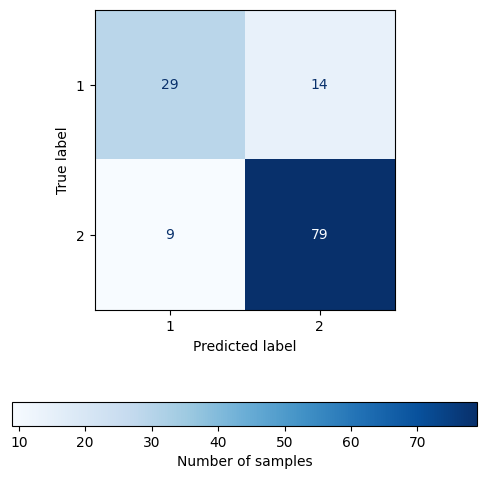

In [33]:
evaluation(y_test_subset, y_pred_label)

In [53]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN

model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer)
model.add(SimpleRNN(
            100,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights)

Epoch 1/20
14/14 [==============================] - 3s 126ms/step - loss: 0.9613 - accuracy: 0.5104 - val_loss: 0.6730 - val_accuracy: 0.6122
Epoch 2/20
14/14 [==============================] - 2s 109ms/step - loss: 0.8707 - accuracy: 0.6328 - val_loss: 0.6601 - val_accuracy: 0.6735
Epoch 3/20
14/14 [==============================] - 1s 105ms/step - loss: 0.8270 - accuracy: 0.6674 - val_loss: 0.6850 - val_accuracy: 0.6122
Epoch 4/20
14/14 [==============================] - 1s 106ms/step - loss: 0.8585 - accuracy: 0.5543 - val_loss: 0.7011 - val_accuracy: 0.5714
Epoch 5/20
14/14 [==============================] - 2s 115ms/step - loss: 0.8513 - accuracy: 0.6236 - val_loss: 0.6441 - val_accuracy: 0.6531
Epoch 6/20
14/14 [==============================] - 2s 116ms/step - loss: 0.8328 - accuracy: 0.6236 - val_loss: 0.6523 - val_accuracy: 0.6531
Epoch 7/20
14/14 [==============================] - 2s 110ms/step - loss: 0.8497 - accuracy: 0.6028 - val_loss: 0.7067 - val_accuracy: 0.4694
Epoch 

5/5 [==============================] - 0s 15ms/step
accuracy: 0.6718


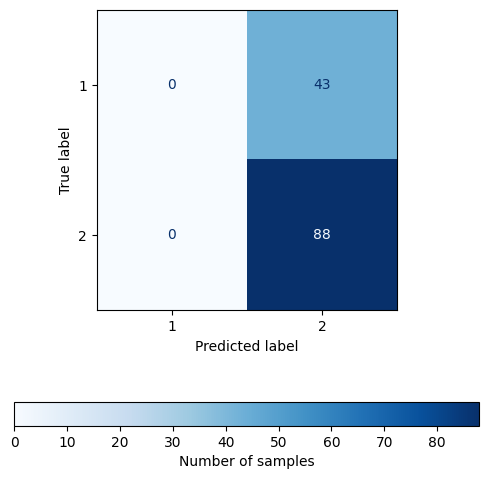

In [54]:
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]
evaluation(y_test_subset, y_pred_label)

In [55]:
# 1 through 5 star ratings
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = Conv1D(64, 3, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [37]:
classes = [0, 1, 2, 3, 4]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(enumerate(class_weights))

In [38]:
model.fit(X_train,
          y_train,
          epochs=50,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/50
18/18 [==============================] - 4s 55ms/step - loss: 1.6138 - accuracy: 0.2085 - val_loss: 1.6074 - val_accuracy: 0.2258
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 1.5479 - accuracy: 0.4540 - val_loss: 1.6685 - val_accuracy: 0.1371
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 1.3951 - accuracy: 0.4332 - val_loss: 1.6453 - val_accuracy: 0.2258
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 1.1229 - accuracy: 0.6101 - val_loss: 1.7370 - val_accuracy: 0.2339
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.8788 - accuracy: 0.7283 - val_loss: 1.9077 - val_accuracy: 0.2177
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7205 - accuracy: 0.7906 - val_loss: 2.0747 - val_accuracy: 0.2097
Epoch 7/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6432 - accuracy: 0.7879 - val_loss: 2.1926 - val_accuracy: 0.2339
Epoch 8/50
18/18 [=

accuracy: 0.2890


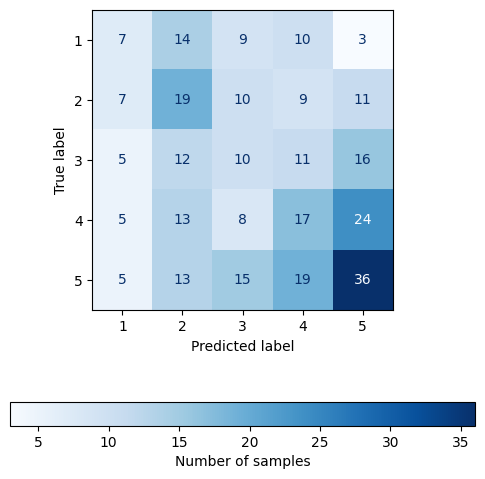

In [39]:
evaluation(y_test, y_pred_label)